### Setup

In [2]:
!pip install --no-deps -q bitsandbytes

In [1]:
import sentencepiece
!pip uninstall -y tokenizers # Uninstall current version
!pip install addict transformers==4.46.3 tokenizers==0.20.3

Found existing installation: tokenizers 0.20.3
Uninstalling tokenizers-0.20.3:
  Successfully uninstalled tokenizers-0.20.3
  Using cached tokenizers-0.20.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
Using cached tokenizers-0.20.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.0 MB)


### OCR

In [3]:
from transformers import AutoModel, AutoTokenizer, BitsAndBytesConfig
import torch

model_name = 'deepseek-ai/DeepSeek-OCR'

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [4]:
qc = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float
)

In [ ]:
import shutil
import os

# Get the root cache directory for the model
model_cache_root_dir = '/root/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-OCR'

# Remove the entire model cache directory if it exists
if os.path.exists(model_cache_root_dir):
    print(f"Removing entire model cache directory: {model_cache_root_dir}")
    shutil.rmtree(model_cache_root_dir, ignore_errors=True)
    print("Entire model cache cleared. Model and tokenizer will be re-downloaded.")
else:
    print(f"Model cache directory not found: {model_cache_root_dir}")

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, use_fast=False)
model = AutoModel.from_pretrained(
    model_name, trust_remote_code=True,
    use_safetensors=True, device_map="auto",
    quantization_config=qc, torch_dtype=torch.float
)
model = model.eval()

Removing entire model cache directory: /root/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-OCR
Entire model cache cleared. Model and tokenizer will be re-downloaded.


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/801 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

modeling_deepseekocr.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/deepseek-ai/DeepSeek-OCR:
- modeling_deepseekocr.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-000001.safetensors:   0%|          | 0.00/6.67G [00:00<?, ?B/s]

In [6]:
prompt = "<image>\n<|grounding|>Convert the document to markdown."
# Prompts examples:
# document: <image>\n<|grounding|>Convert the document to markdown.
# other image: <image>\n<|grounding|>OCR this image.
# without layouts: <image>\nFree OCR.
# figures in document: <image>\nParse the figure.
# general: <image>\nDescribe this image in detail.
# rec: <image>\nLocate <|ref|>xxxx<|/ref|> in the image.

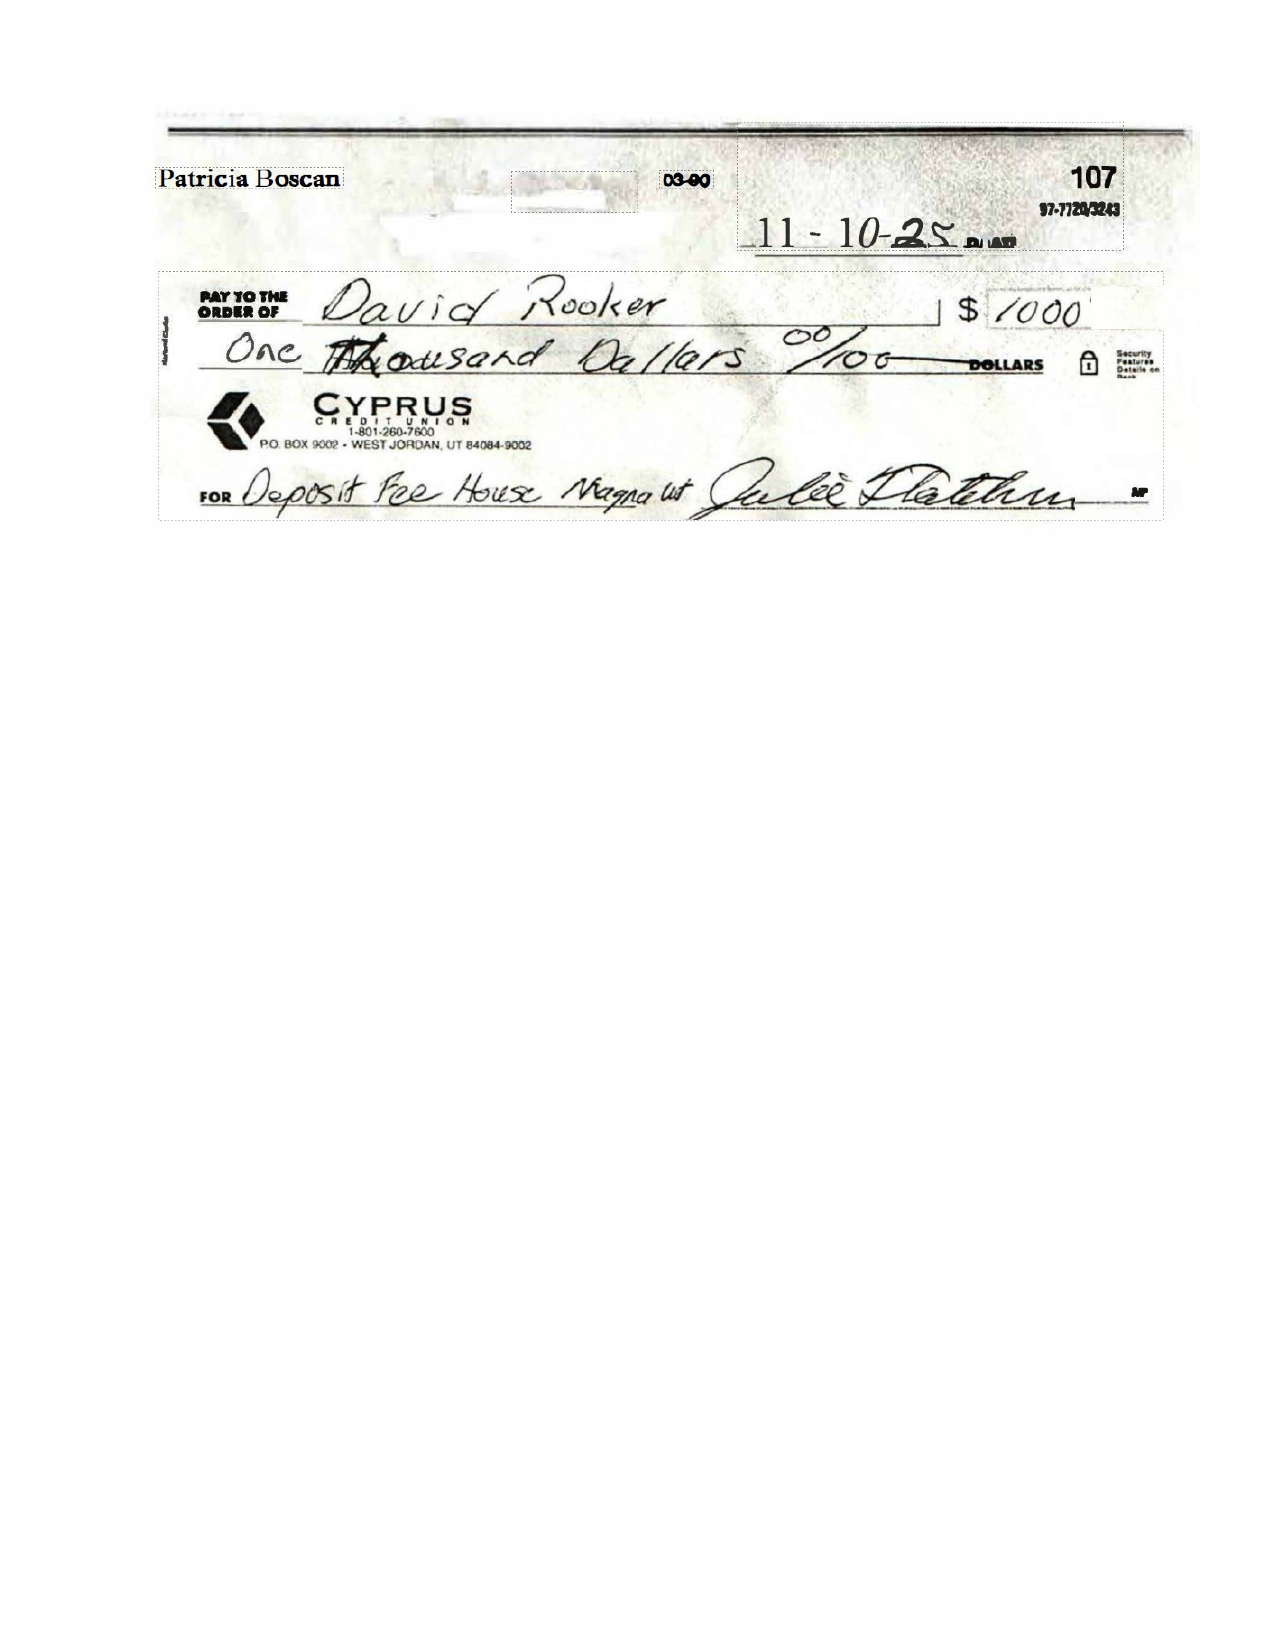

In [8]:
image_file = "/content/16.1 EMD Check_page-0001 (1).jpg"
from IPython.display import Image
Image(image_file, width=640)

In [9]:
with torch.no_grad():
    res = model.infer(
        tokenizer,
        prompt=prompt,
        image_file=image_file,
        output_path=".",
        base_size=1024,
        image_size=1024,
        crop_mode=False,
        save_results=True,
        test_compress=True,
        eval_mode=False
    )

/usr/local/lib/python3.12/dist-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.
`get_max_cache()` is deprecated for all Cache classes. Use `get_max_cache_shape()` instead. Cal

BASE:  torch.Size([1, 256, 1280])
NO PATCHES
<|ref|>image<|/ref|><|det|>[[112, 66, 927, 320]]<|/det|>
image size:  (1275, 1650)
valid image tokens:  197
output texts tokens (valid):  18
compression ratio:  0.09
===============save results:===============


image: 100%|██████████| 1/1 [00:00<00:00, 11366.68it/s]
other: 0it [00:00, ?it/s]


In [1]:
import os

output_markdown_file = "result.md"
if os.path.exists(output_markdown_file):
    with open(output_markdown_file, "r") as f:
        markdown_content = f.read()
    print(markdown_content)
else:
    print(f"Markdown output file not found: {output_markdown_file}")

Markdown output file not found: result.md


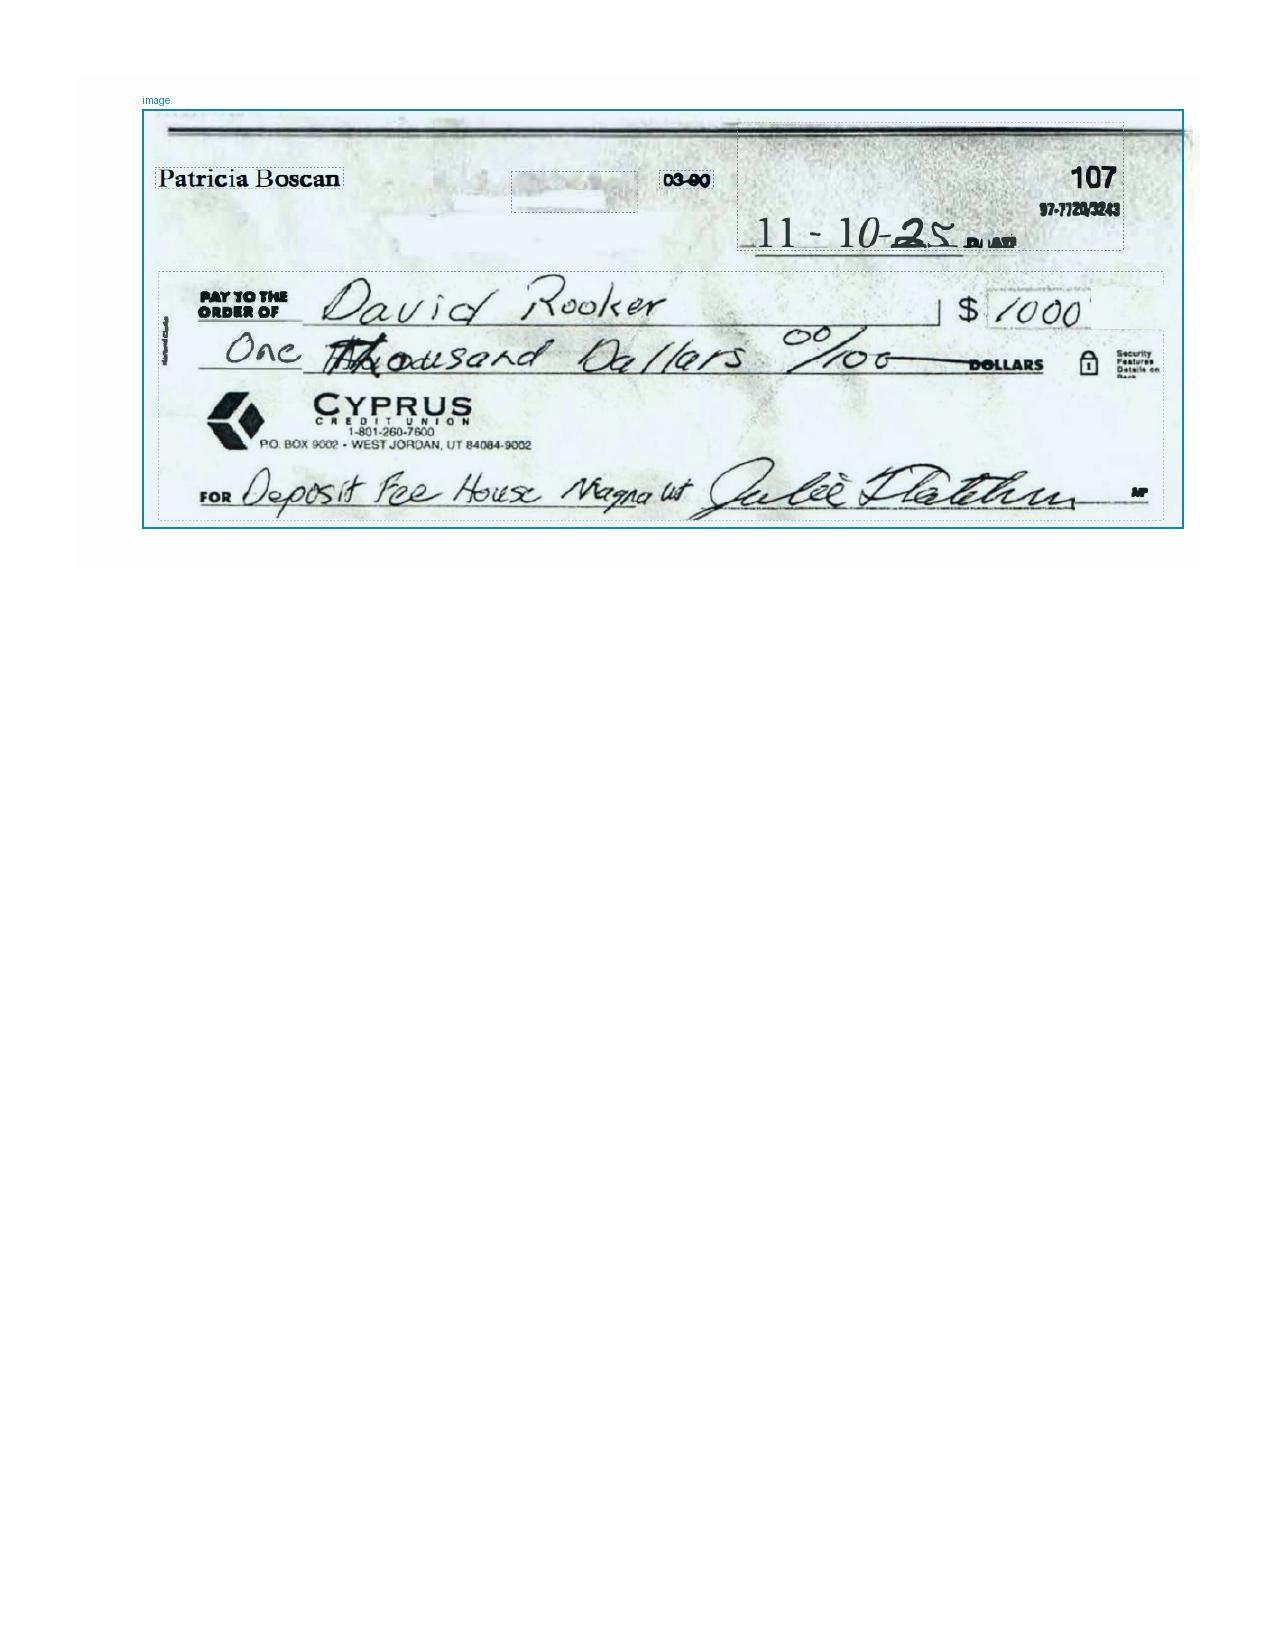

In [12]:
Image("result_with_boxes.jpg", width=640)

<div style="
background: linear-gradient(135deg, #e8f5e9, #f1f8e9);
border: 2px solid #4CAF50;
border-radius: 14px;
padding: 18px;
text-align: center;
color: #1b5e20;
font-family: 'Segoe UI', sans-serif;
font-size: 1.1em;
box-shadow: 0 4px 12px rgba(0,0,0,0.08);
">

<b>📘 Vision Class — Deep Learning & Computer Vision</b><br><br>

🔗 <a href="https://class.vision" target="_blank" style="color:#1b5e20; font-weight:600;">
https://class.vision</a><br><br>

📣 Telegram Channels:<br>
<a href="https://t.me/cvision" target="_blank" style="color:#2e7d32; font-weight:bold;">@cvision</a> |
<a href="https://t.me/class_vision" target="_blank" style="color:#2e7d32; font-weight:bold;">@class_vision</a> |
<a href="https://t.me/llm_huggingface" target="_blank" style="color:#2e7d32; font-weight:bold">@llm_huggingface</a>

</div>
